## Import packages.

In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

#rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 23
rcParams['font.weight'] = 300


## Start with mock.

> Simple double Gaussian.

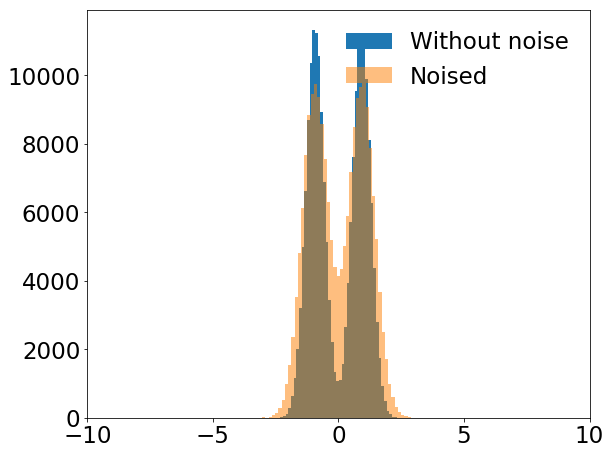

In [24]:
# number of dimensions
dim_in = 5
sample_size = 1e5

# make double Gaussian
z1 = np.random.multivariate_normal(np.zeros(dim_in), np.eye(dim_in), int(sample_size))
z2 = np.random.multivariate_normal(np.zeros(dim_in), np.eye(dim_in), int(sample_size)) - 5

# combine sample
age = np.vstack([z1,z2])

#------------------------------------------------------------------------------------------------
# randomize
ind_shuffle = np.arange(age.shape[0])
age = age[ind_shuffle]

# add noise
age_noised = np.copy(age)
age_noised += np.random.normal(size=age.shape)

# renormalized 
mu_age = np.mean(age, axis=0)
std_age = np.std(age, axis=0)
age = (age-mu_age)/std_age
age_noised = (age_noised-mu_age)/std_age

#------------------------------------------------------------------------------------------------
# plot the histogram
plt.hist(age[:,0],bins=50, label="Without noise");
plt.hist(age_noised[:,0],bins=50, alpha=0.5, label="Noised");
plt.legend(frameon=False)
plt.xlim([-10,10])

# save training set
np.savez("../mock_gaussians.npz", age=age, age_noised=age_noised)


> Re-predict results.

In [31]:
# import training set
temp = np.load("../mock_gaussians.npz")
y_tr = temp["age_noised"] # with noise

# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)
dim_in = 5

# standardize
#mu_y = y_tr.mean(dim=0)
#std_y = y_tr.std(dim=0)
#y_tr = (y_tr - mu_y) / std_y

#==================================================================================
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()
flow2 = torch.load("../flow2_final.pt", map_location=lambda storage, loc: storage) # load in cpu
flow2.eval()

# sample results
z1 = flow.f(y_tr)[0].detach().numpy()
x1 = y_tr
z2 = np.random.multivariate_normal(np.zeros(dim_in), np.eye(dim_in), x1.shape[0])

#x2 = flow.sample(torch.from_numpy(z2).type(torch.FloatTensor))
x2, _ = flow2.f(flow2.g(flow.sample(torch.from_numpy(z2).type(torch.FloatTensor))))

# rescale the results
#x1 = x1*std_y + mu_y
#x2 = x2*std_y + mu_y

# convert back to numpy
x1 = x1.detach().numpy()
x2 = x2.detach().numpy()

#---------------------------------------------------------------------------------------
# save results
np.savez("../real_nvp_deconvolution_results.npz",\
         z1 = z1,\
         z2 = z2,\
         x1 = x1,\
         x2 = x2)


> Plot results.

(200000, 5)
(200000, 5)


Text(0.5, 1.0, '$X \\sim p(X)$ [2D]')

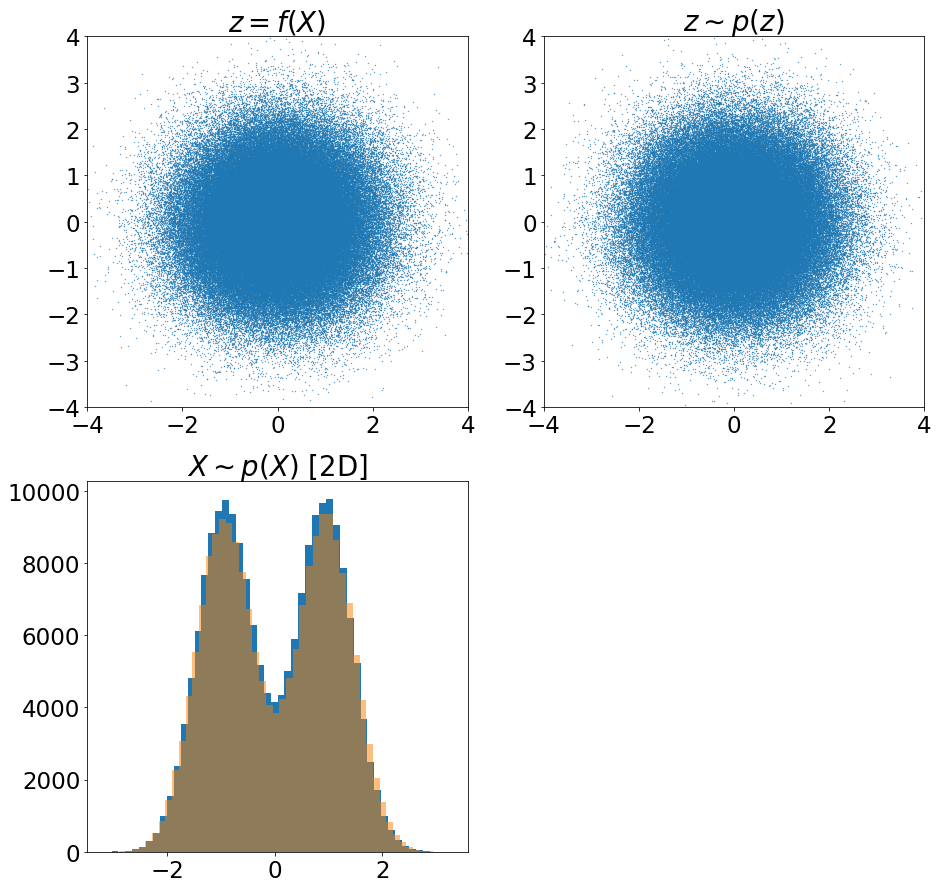

In [32]:
# setup figure
plt.figure(figsize=[15,15]);

# the latent space
temp = np.load("../real_nvp_deconvolution_results.npz")
z = temp["z1"]
print(z.shape)
plt.subplot(221)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.scatter(z[:, 0], z[:, 1], s=0.1)
plt.title(r'$z = f(X)$')

z = temp["z2"]
print(z.shape)
plt.subplot(222)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.scatter(z[:, 0], z[:, 1], s=0.1)
plt.title(r'$z \sim p(z)$')

#-----------------------------------------------------------------------------------------
# the 2D feature space
x1 = temp["x1"]
x2 = temp["x2"]
plt.subplot(223)
plt.hist(x1[:, 0], bins=50)
plt.hist(x2[:, 0], bins=50, alpha=0.5)
plt.title(r'$X \sim p(X)$ [2D]')


## GALAH age distribution.

> Plot the distribution.

In [ ]:
# restore data
temp = np.load("ages.npz")
print(temp.files)
age = temp["age"].astype("float32")
age = age.reshape(age.size,1)
print(age.shape)

plt.hist(age, bins=100);

In [ ]:
# restore data
temp = np.load("weighted_ages.npz")
print(temp.files)
age = temp["age"].astype("float32")[::300]
age = age.reshape(age.size,1)
print(age.shape)

plt.hist(age, bins=100);

> Plot $\sigma$(age) as a function of age.

In [ ]:
# color coded in log scale
plt.hexbin(age, eage, bins='log')

> Plot results.

In [ ]:
# setup figure
plt.figure(figsize=[15,22]);

# the latent space
temp = np.load("real_nvp_results.npz")
z = temp["z1"]
print(z.shape)
plt.subplot(321)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.scatter(z[:, 0], z[:, 1], s=0.1)
plt.title(r'$z = f(X)$')

z = temp["z2"]
print(z.shape)
plt.subplot(322)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.scatter(z[:, 0], z[:, 1], s=0.1)
plt.title(r'$z \sim p(z)$')

#-----------------------------------------------------------------------------------------
# the 2D feature space
x = temp["x1"]
print(x.shape)
plt.subplot(323)
plt.xlim([0,20])
plt.ylim([0,20])
plt.scatter(x[:, 0], x[:, 1], c='r', s=0.1)
plt.title(r'$X \sim p(X)$ [2D]')

x = temp["x2"]
print(x.shape)
plt.subplot(324)
plt.xlim([0,20])
plt.ylim([0,20])
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r', s=0.1)
plt.title(r'$X = g(z)$ [2D]')

#-----------------------------------------------------------------------------------------
# 1D feature histogram
plt.subplot(325)

x = temp["x1"]
plt.hist(x[:, 0], bins=100, range=[0,20])

x = temp["x2"]
plt.hist(x[:, :, 0], alpha=0.5, bins=100, range=[0,20])

plt.title(r'$X \sim p(X)$ [1D]')
